In [2]:
# Date: 28/05/2021
# Title: Titanic Project.
# Author: Parmeshwar Prajapati.

---
### 1. Importing modules.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sb

import scipy.stats as scistats

---
### 2. Importing data.

In [2]:
raw_train = pd.read_csv('train.csv')
raw_test = pd.read_csv('test.csv')

print(raw_train.shape)
print(raw_test.shape)

(891, 12)
(418, 11)


#### 2.1. Quick glance at the data.

In [151]:
raw_train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [3]:
# Dropping 'PassengerId'.

raw_train.drop(columns = ['PassengerId'], inplace = True)
raw_test.drop(columns = ['PassengerId'], inplace = True)

print('Raw train data shape:', raw_train.shape)
print('Raw test data shape:', raw_test.shape)

Raw train data shape: (891, 11)
Raw test data shape: (418, 10)


In [4]:
# Checking for null values in target data.

print('Null values in target feature:', 
      raw_train['Survived'].isnull().sum().sum())

Null values in target feature: 0


#### 2.2. Describing the data.

In [154]:
raw_train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
raw_train.describe(include = 'object')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Brown, Mrs. James Joseph (Margaret Tobin)",male,347082,B96 B98,S
freq,1,577,7,4,644


#### 2.3. Checking the data types.

In [6]:
raw_train.dtypes

Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [7]:
# Comparing the dtypes.

print('Data types are same in training and testing dataset:', 
      all((raw_train.dtypes[1:] == raw_test.dtypes).values))


Data types are same in training and testing dataset: True


---
### 3. EDA

#### 3.1. Checking for null values.

In [5]:
train_null_data = (raw_train.isnull().sum()/raw_train.shape[0])*100
train_null_col25 = train_null_data[train_null_data > 25].keys().to_list()

test_null_data = (raw_test.isnull().sum()/raw_test.shape[0])*100
test_null_col25 = test_null_data[test_null_data > 25].keys().to_list()

print('Null columns in train data with more than 25% null values are:', 
      train_null_col25)
print('Null columns in test data with more than 25% null values are:', 
      test_null_col25)

Null columns in train data with more than 25% null values are: ['Cabin']
Null columns in test data with more than 25% null values are: ['Cabin']


In [6]:
# Checking whether the above column can be dropped or not.

# 1) 891 tickets are present so everyone should have a Cabin.
# 2) If the null values are filled with 'mode' or 'median' values then more 
# people will have same Cabin which cannot be True.

# Dropping 'Cabin' column from both the dataset.
raw_train.drop(columns = 'Cabin', inplace = True)
raw_test.drop(columns = 'Cabin', inplace = True)

#### 3.2. Checking columns with low variance.

In [10]:
# Columns with low variance.

raw_train.var()

Survived       0.236772
Pclass         0.699015
Age          211.019125
SibSp          1.216043
Parch          0.649728
Fare        2469.436846
dtype: float64

In [11]:
# The above columns have low variance due to low value range except age.

In [9]:
# Making changes in Name column.

import re

In [10]:
def extract_desig(data):
    pattern = re.compile(',\s\w+')
    match_list = []

    for string in list(data.Name.values):
        matches = pattern.finditer(string)

        for match in matches:
            match_list.append(match[0][2:])
            
    return match_list

In [11]:
raw_train['Desig'] = extract_desig(raw_train)
raw_test['Desig'] = extract_desig(raw_test)

In [12]:
raw_train['Desig'].value_counts().keys()

Index(['Mr', 'Miss', 'Mrs', 'Master', 'Dr', 'Rev', 'Col', 'Major', 'Mlle',
       'Mme', 'Capt', 'Don', 'Ms', 'Lady', 'Sir', 'Jonkheer', 'the'],
      dtype='object')

In [13]:
raw_test['Desig'].value_counts().keys()

Index(['Mr', 'Miss', 'Mrs', 'Master', 'Col', 'Rev', 'Ms', 'Dona', 'Dr'], dtype='object')

In [14]:
list(set(raw_train['Desig'].value_counts().keys()).difference(set(raw_test['Desig'].value_counts().keys())))

['Sir', 'Lady', 'Major', 'Don', 'Mme', 'Capt', 'Mlle', 'Jonkheer', 'the']

In [15]:
check_desig = ['Rev', 'Mlle', 'the',  'Jonkheer', 'Mme', 'Don']
vals = False

for des in check_desig:
    vals = vals | (raw_train.Desig == des)

In [16]:
raw_train[vals]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Desig
30,0,1,"Uruchurtu, Don. Manuel E",male,40.0,0,0,PC 17601,27.7208,C,Don
149,0,2,"Byles, Rev. Thomas Roussel Davids",male,42.0,0,0,244310,13.0000,S,Rev
150,0,2,"Bateman, Rev. Robert James",male,51.0,0,0,S.O.P. 1166,12.5250,S,Rev
249,0,2,"Carter, Rev. Ernest Courtenay",male,54.0,1,0,244252,26.0000,S,Rev
369,1,1,"Aubart, Mme. Leontine Pauline",female,24.0,0,0,PC 17477,69.3000,C,Mme
626,0,2,"Kirkland, Rev. Charles Leonard",male,57.0,0,0,219533,12.3500,Q,Rev
641,1,1,"Sagesser, Mlle. Emma",female,24.0,0,0,PC 17477,69.3000,C,Mlle
710,1,1,"Mayne, Mlle. Berthe Antonine (""Mrs de Villiers"")",female,24.0,0,0,PC 17482,49.5042,C,Mlle
759,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,110152,86.5000,S,the
822,0,1,"Reuchlin, Jonkheer. John George",male,38.0,0,0,19972,0.0000,S,Jonkheer


In [17]:
raw_test['Desig'].replace('Dona', 'Don', inplace = True)

In [18]:
raw_test['Desig'].value_counts().keys()

Index(['Mr', 'Miss', 'Mrs', 'Master', 'Col', 'Rev', 'Don', 'Ms', 'Dr'], dtype='object')

In [19]:
raw_train.drop(columns = ['Name'], inplace = True)
raw_test.drop(columns = ['Name'], inplace = True)

print('Raw train data shape:', raw_train.shape)
print('Raw test data shape:', raw_test.shape)

Raw train data shape: (891, 10)
Raw test data shape: (418, 9)


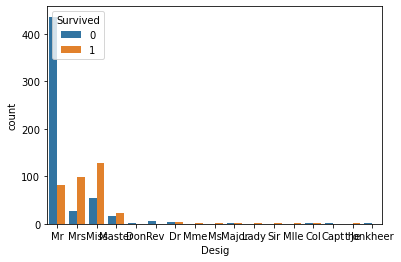

In [25]:
sb.countplot(x = raw_train.Desig, 
             hue = raw_train.Survived)
plt.show()

#### 3.3. Splitting the data.

In [20]:
# Splitting data.
# Data is too small using stratified shuffle split

from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, 
                                  random_state = 0)

for train_index, valid_index in splitter.split(raw_train, raw_train['Survived']):
    train_data = raw_train.iloc[train_index]
    valid_data = raw_train.iloc[valid_index]
    
train_data.reset_index(drop = True, inplace = True)
valid_data.reset_index(drop = True, inplace = True)

In [21]:
# Checking the shapes.

print('Shape of training data:', train_data.shape)
print('Shape of testing data:', valid_data.shape)

Shape of training data: (712, 10)
Shape of testing data: (179, 10)


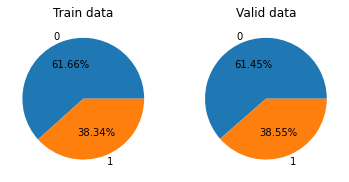

In [176]:
# Checking the proportions.

pie_train = train_data['Survived'].value_counts()/train_data.shape[0]*100
pie_valid = valid_data['Survived'].value_counts()/valid_data.shape[0]*100

plt.Figure(figsize = (8, 8))
plt.subplot(121)
plt.title('Train data')
plt.pie(x = pie_train.to_list(), labels = pie_train.index.to_list(), 
        autopct = '%1.2f%%')

plt.subplot(122)
plt.title('Valid data')
plt.pie(x = pie_valid.to_list(), labels = pie_valid.index.to_list(), 
        autopct = '%1.2f%%')
plt.show()

#### 3.4. Checking for valid zeros.

In [28]:
(train_data == 0).sum()

Survived    439
Pclass        0
Sex           0
Age           0
SibSp       486
Parch       546
Ticket        0
Fare         12
Embarked      0
Desig         0
dtype: int64

In [29]:
# Survived, SibSp and Parch columns can have zero values.
# Checking for Fare.

train_data[train_data['Fare'] == 0]

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Desig
28,0,3,male,49.0,0,0,LINE,0.0,S,Mr
45,0,2,male,NaN,0,0,239856,0.0,S,Mr
62,0,1,male,NaN,0,0,112058,0.0,S,Mr
208,0,1,male,40.0,0,0,112059,0.0,S,Mr
218,0,1,male,38.0,0,0,19972,0.0,S,Jonkheer
258,0,3,male,36.0,0,0,LINE,0.0,S,Mr
314,0,2,male,NaN,0,0,239855,0.0,S,Mr
349,0,1,male,39.0,0,0,112050,0.0,S,Mr
386,0,2,male,NaN,0,0,239853,0.0,S,Mr
420,0,2,male,NaN,0,0,239853,0.0,S,Mr


In [22]:
# Checking for minimum age.

train_data[train_data['Fare'] == 0]['Age'].min()

25.0

In [23]:
valid_data[valid_data['Fare'] == 0]

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Desig
5,0,1,male,NaN,0,0,112052,0.0,S,Mr
111,0,2,male,NaN,0,0,239853,0.0,S,Mr
172,0,3,male,19.0,0,0,LINE,0.0,S,Mr


In [24]:
# Checking for minimum age.

valid_data[valid_data['Fare'] == 0]['Age'].min()

19.0

In [25]:
raw_test[raw_test['Fare'] == 0]

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Desig
266,1,male,NaN,0,0,112051,0.0,S,Mr
372,1,male,49.0,0,0,112058,0.0,S,Mr


In [26]:
# Checking for minimum age.

raw_test[raw_test['Fare'] == 0]['Age'].min()

49.0

In [27]:
# As we all know people with Age above 25 should pay for their ticket.
# So, we need to replace those zeros.

#### 3.5. Checking for null columns.

In [28]:
# Finding null columns.

train_null_data = train_data.isnull().sum()
train_null_cols = train_null_data[train_null_data > 0].keys().to_list()

valid_null_data = valid_data.isnull().sum()
valid_null_cols = valid_null_data[valid_null_data > 0].keys().to_list()

test_null_data = raw_test.isnull().sum()
test_null_cols = test_null_data[test_null_data > 0].keys().to_list()

print('Null columns in Training data are:', train_null_cols)
print('Null columns in Validation data are:', valid_null_cols)
print('Null columns in Test data are:', test_null_cols)

Null columns in Training data are: ['Age', 'Embarked']
Null columns in Validation data are: ['Age']
Null columns in Test data are: ['Age', 'Fare']


#### 3.6. Imputing the data.

In [29]:
from sklearn.impute import SimpleImputer

In [30]:
imp = SimpleImputer(strategy = 'most_frequent')

train_data_ = train_data.drop(columns = 'Survived')
valid_data_ = valid_data.drop(columns = 'Survived')

temp_train_data = imp.fit_transform(train_data_)
temp_valid_data = imp.transform(valid_data_)
temp_test_data = imp.transform(raw_test)

imp_train_data = pd.DataFrame(temp_train_data, 
                              columns = train_data_.columns.to_list())
imp_valid_data = pd.DataFrame(temp_valid_data, 
                              columns = valid_data_.columns.to_list())
imp_test_data = pd.DataFrame(temp_test_data, 
                             columns = raw_test.columns.to_list())

imp_train_data = pd.concat([imp_train_data, train_data['Survived']], 
                           axis = 1)
imp_valid_data = pd.concat([imp_valid_data, valid_data['Survived']], 
                           axis = 1)

print('Shape of trainig data:', imp_train_data.shape)
print('Shape of valid data:',imp_valid_data.shape)
print('Shape of testing data:',imp_test_data.shape)

Shape of trainig data: (712, 10)
Shape of valid data: (179, 10)
Shape of testing data: (418, 9)


In [31]:
# Cross checking for null values.

print('Null values in trainig data:',imp_train_data.isnull().sum().sum())
print('Null values in valid data:',imp_valid_data.isnull().sum().sum())
print('Null values in testing data:',imp_test_data.isnull().sum().sum())

Null values in trainig data: 0
Null values in valid data: 0
Null values in testing data: 0


#### 3.7. Correcting the data type.

In [32]:
cols = imp_train_data.columns.to_list()
cols.remove('Survived')

for col in cols:
    imp_train_data[col] = imp_train_data[col].astype(type(imp_train_data[col][0]))
    imp_valid_data[col] = imp_valid_data[col].astype(type(imp_valid_data[col][0]))
    imp_test_data[col] = imp_test_data[col].astype(type(imp_test_data[col][0]))

In [33]:
# Cross checking

imp_train_data.dtypes

Pclass        int32
Sex          object
Age         float64
SibSp         int32
Parch         int32
Ticket       object
Fare        float64
Embarked     object
Desig        object
Survived      int64
dtype: object

#### 3.8. Filling the zero values.

In [34]:
zero_fare = imp_train_data[['Fare', 'Age']].groupby('Age').mean().to_dict()['Fare']
fare_index = imp_train_data.columns.get_indexer(['Fare'])

for index in imp_train_data[imp_train_data['Fare'] == 0].index:
    val = zero_fare[imp_train_data.iloc[index, :]['Age']]
    imp_train_data.iloc[index, fare_index] = val

In [35]:
# Cross checking

any(imp_train_data['Fare'] == 0)

False

In [36]:
zero_fare = imp_valid_data[['Fare', 'Age']].groupby('Age').mean().to_dict()['Fare']
fare_index = imp_valid_data.columns.get_indexer(['Fare'])

for index in imp_valid_data[imp_valid_data['Fare'] == 0].index:
    val = zero_fare[imp_valid_data.iloc[index, :]['Age']]
    imp_valid_data.iloc[index, fare_index] = val
    
# Cross checking
any(imp_valid_data['Fare'] == 0)

False

In [37]:
zero_fare = imp_test_data[['Fare', 'Age']].groupby('Age').mean().to_dict()['Fare']
fare_index = imp_test_data.columns.get_indexer(['Fare'])

for index in imp_test_data[imp_test_data['Fare'] == 0].index:
    val = zero_fare[imp_test_data.iloc[index, :]['Age']]
    imp_test_data.iloc[index, fare_index] = val
    
# Cross checking
any(imp_test_data['Fare'] == 0)

False

### 4. Exploring data.

In [47]:
# Using tableau to visualize data.

imp_train_data.to_csv('imp_train_data.csv')

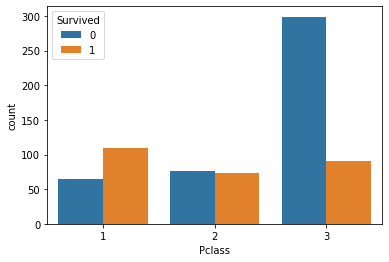

In [66]:
sb.countplot(x = imp_train_data['Pclass'], hue = imp_train_data['Survived'])
plt.show()

Individuals belonging to Pclass 3 have less chance of surviving.

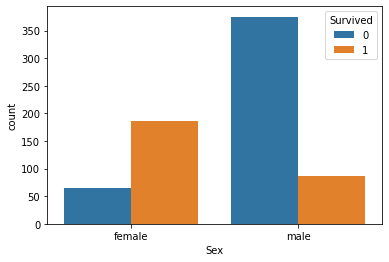

In [67]:
sb.countplot(x = imp_train_data['Sex'], hue = imp_train_data['Survived'])
plt.show()

Males have less chance of surviving.

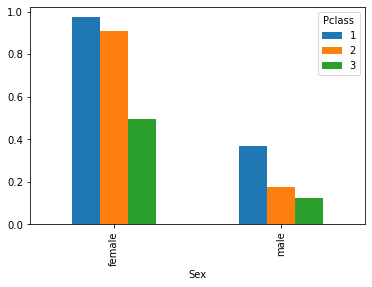

In [68]:
imp_train_data.pivot_table('Survived', index = 'Sex', columns = 'Pclass').plot(kind = 'bar')
plt.show()

Females of all the class have higher chance of survival than males.

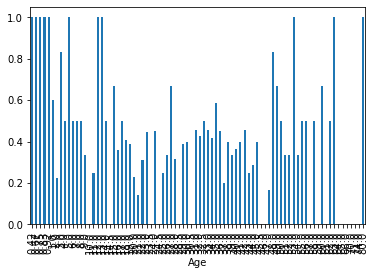

In [69]:
imp_train_data.groupby('Age')['Survived'].mean().plot(kind = 'bar')
plt.show()

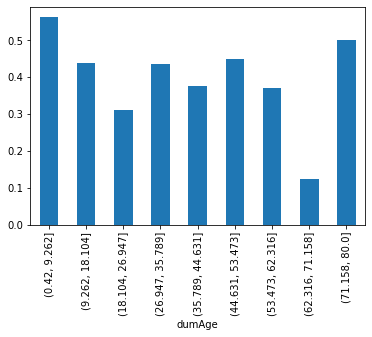

In [70]:
# For visualization.

imp_train_data['dumAge'] = pd.cut(imp_train_data['Age'], 
                                   bins = np.linspace(imp_train_data['Age'].min(),
                                                      imp_train_data['Age'].max(), 10))

imp_train_data.groupby('dumAge')['Survived'].mean().plot(kind = 'bar')
plt.show()

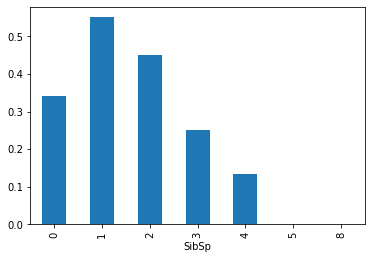

In [71]:
imp_train_data.groupby('SibSp')['Survived'].mean().plot(kind = 'bar')
plt.show()

Chance of survival is highest if number of SibSp is 1.

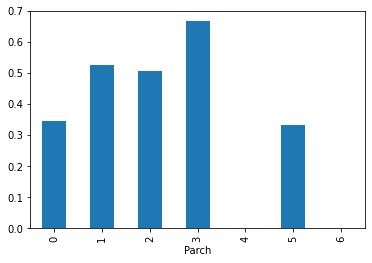

In [72]:
imp_train_data.groupby('Parch')['Survived'].mean().plot(kind = 'bar')
plt.show()

Chance of survival is highest if number of Parch is 3.

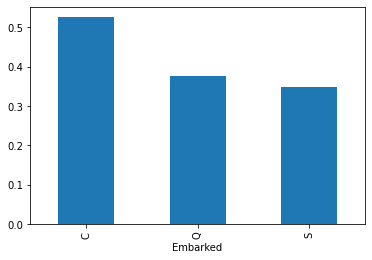

In [73]:
imp_train_data.groupby('Embarked')['Survived'].mean().plot(kind = 'bar')
plt.show()

Chance of survival is highest if Embarked from port 'C'.

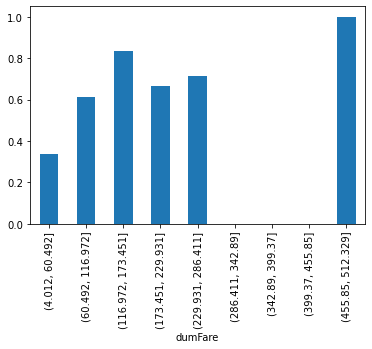

In [74]:
imp_train_data['dumFare'] = pd.cut(imp_train_data['Fare'], 
                                   bins = np.linspace(imp_train_data['Fare'].min(),
                                                      imp_train_data['Fare'].max(), 10))

imp_train_data.groupby('dumFare')['Survived'].mean().plot(kind = 'bar')
plt.show()

In [75]:
# Dropping unnecessary columns.

imp_train_data = imp_train_data.drop(columns = ['dumFare', 'dumAge'])

### 5. Assumptions for Logistic Regression.

In [76]:
# Assumptions: -
# 1) Independent features.
# 2) Normally distributed.
# 3) No outliers.

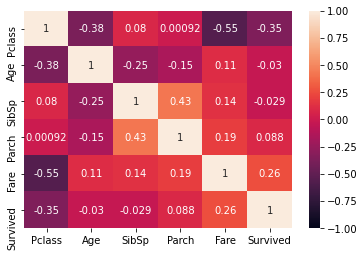

In [195]:
# 1) Independent features.

corr_matrix = imp_train_data.corr()
sb.heatmap(corr_matrix, annot = True, vmin = -1, vmax = 1)
plt.show()

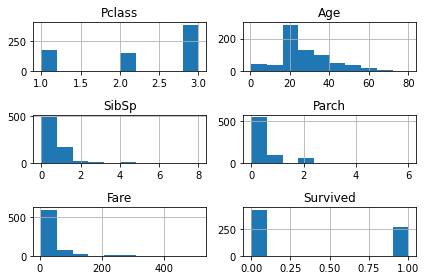

In [78]:
# 2) Normally distributed.

imp_train_data.hist()
plt.tight_layout()
plt.show()

In [79]:
# Data is not normally distributed.

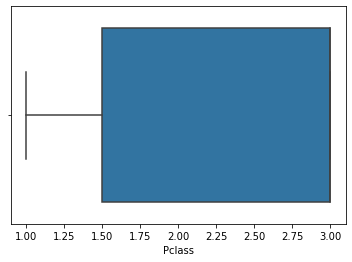

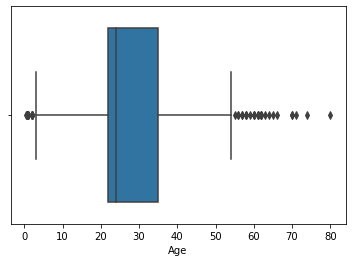

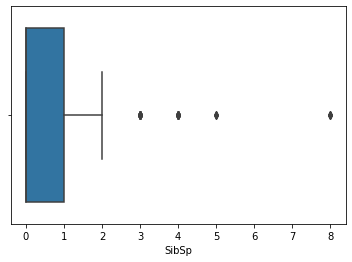

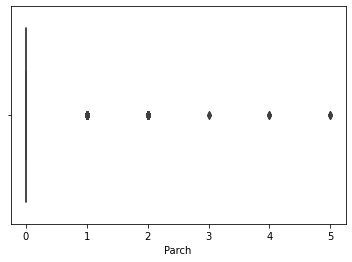

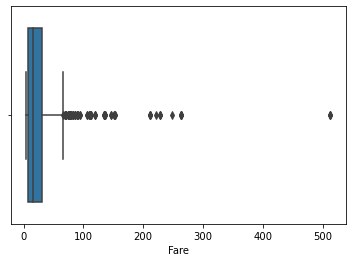

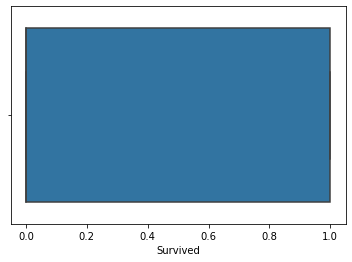

In [183]:
# 3) No outliers.

for col in imp_train_data.select_dtypes(exclude = 'object').columns:
    sb.boxplot(x = imp_train_data[col])
    plt.show()

In [38]:
# Removing outliers.

imp_train_data = imp_train_data[imp_train_data['Fare'] < 400]

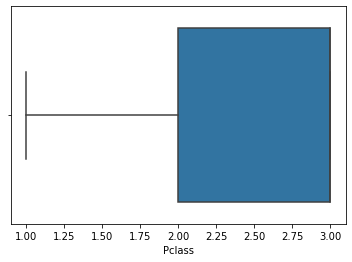

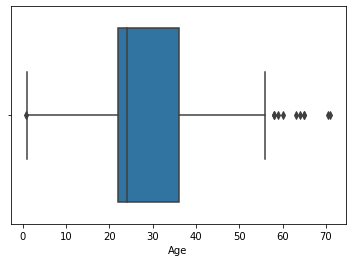

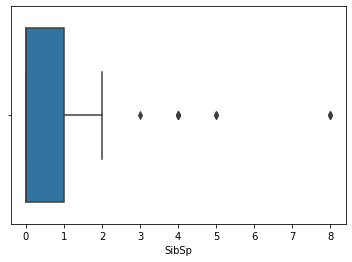

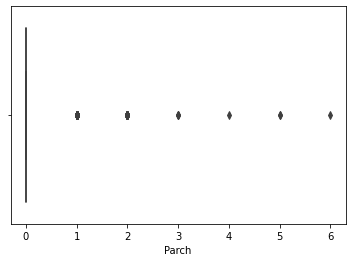

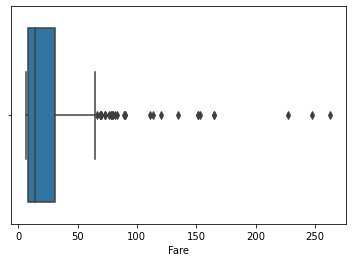

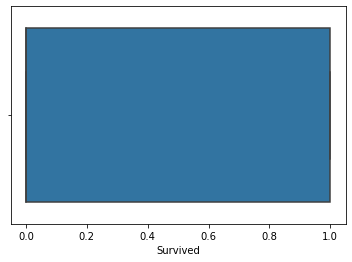

In [185]:
for col in imp_valid_data.select_dtypes(exclude = 'object').columns:
    sb.boxplot(x = imp_valid_data[col])
    plt.show()

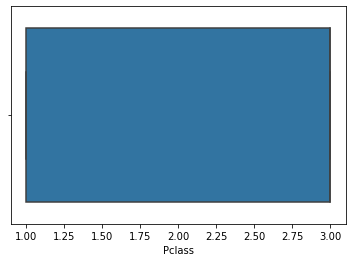

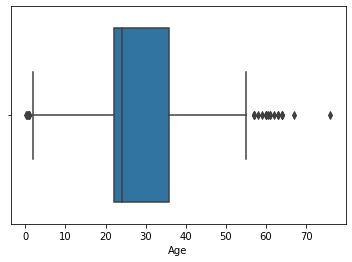

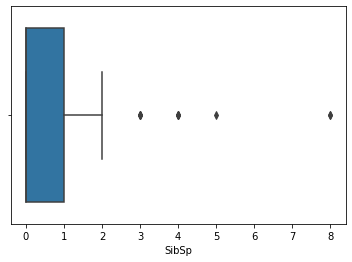

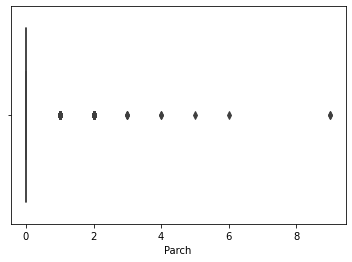

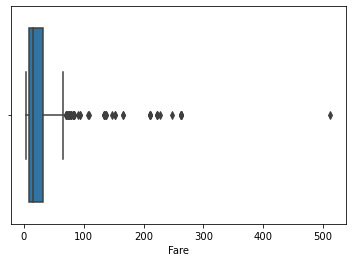

In [186]:
for col in imp_test_data.select_dtypes(exclude = 'object').columns:
    sb.boxplot(x = imp_test_data[col])
    plt.show()

In [39]:
# Splitting the features and target variables.

y_train = imp_train_data['Survived']
imp_train_data = imp_train_data.drop(columns = ['Survived'])

y_valid = imp_valid_data['Survived']
imp_valid_data = imp_valid_data.drop(columns = 'Survived')

### 6. Feature Engineering.

In [40]:
imp_train_data_ = imp_train_data.copy()
imp_valid_data_ = imp_valid_data.copy()
imp_test_data_ = imp_test_data.copy()

#### 6.1. Ordinal Encoding.

In [41]:
# Converting 'Pclass' to str

imp_train_data_.loc[:, 'Pclass'] = imp_train_data_.loc[:, 'Pclass'].astype(str)
imp_valid_data_.loc[:, 'Pclass'] = imp_valid_data_.loc[:, 'Pclass'].astype(str)
imp_test_data_.loc[:, 'Pclass'] = imp_test_data_.loc[:, 'Pclass'].astype(str)

In [42]:
# Mapping the values.

imp_train_data_['Pclass'] = imp_train_data_['Pclass'].map({'3': 1, '2': 2, '1': 3})
imp_valid_data_['Pclass'] = imp_valid_data_['Pclass'].map({'3': 1, '2': 2, '1': 3})
imp_test_data_['Pclass'] = imp_test_data_['Pclass'].map({'3': 1, '2': 2, '1': 3})

#### 6.2. Log transformation on skewed data.

In [43]:
# Checking for skewed data.

num_train_data = imp_train_data_.select_dtypes(exclude = 'object')
skewness = num_train_data.apply(lambda x: scistats.skew(x))
train_skewed_cols = skewness[abs(skewness) > 0.75].keys().to_list()
print('Skewed columns are:', train_skewed_cols)

num_valid_data = imp_valid_data_.select_dtypes(exclude = 'object')
skewness = num_valid_data.apply(lambda x: scistats.skew(x))
valid_skewed_cols = skewness[abs(skewness) > 0.75].keys().to_list()
print('Skewed columns are:', valid_skewed_cols)

num_test_data = imp_test_data_.select_dtypes(exclude = 'object')
skewness = num_test_data.apply(lambda x: scistats.skew(x))
test_skewed_cols = skewness[abs(skewness) > 0.75].keys().to_list()
print('Skewed columns are:', test_skewed_cols)

Skewed columns are: ['SibSp', 'Parch', 'Fare']
Skewed columns are: ['SibSp', 'Parch', 'Fare']
Skewed columns are: ['Age', 'SibSp', 'Parch', 'Fare']


In [44]:
# Applying log transformation.

log_train_data = np.log1p(imp_train_data_.loc[:, test_skewed_cols])
imp_train_data_.drop(columns = test_skewed_cols, inplace = True)
log_train_data.reset_index(drop = True, inplace = True)

log_valid_data = np.log1p(imp_valid_data_.loc[:, test_skewed_cols])
imp_valid_data_.drop(columns = test_skewed_cols, inplace = True)
log_valid_data.reset_index(drop = True, inplace = True)

log_test_data = np.log1p(imp_test_data_.loc[:, test_skewed_cols])
imp_test_data_.drop(columns = test_skewed_cols, inplace = True)
log_test_data.reset_index(drop = True, inplace = True)

In [45]:
# Cross checking for null values.

print('Null values in log_train_data:', log_train_data.isnull().sum().sum())
print('Null values in log_valid_data:', log_valid_data.isnull().sum().sum())
print('Null values in log_test_data:', log_test_data.isnull().sum().sum())

Null values in log_train_data: 0
Null values in log_valid_data: 0
Null values in log_test_data: 0


In [46]:
# Checking for shape.

print('Shape of log_train_data:', log_train_data.shape)
print('Shape of log_valid_data:', log_valid_data.shape)
print('Shape of log_test_data:', log_test_data.shape)

Shape of log_train_data: (709, 4)
Shape of log_valid_data: (179, 4)
Shape of log_test_data: (418, 4)


In [47]:
# Splitting numerical and categorical data.

num_train_data = imp_train_data_.select_dtypes(exclude = 'object')
obj_train_data = imp_train_data_.select_dtypes(include = 'object')

num_valid_data = imp_valid_data_.select_dtypes(exclude = 'object')
obj_valid_data = imp_valid_data_.select_dtypes(include = 'object')

num_test_data = imp_test_data_.select_dtypes(exclude = 'object')
obj_test_data = imp_test_data_.select_dtypes(include = 'object')

#### 6.3. Scaling and One hot encoding.

In [48]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [49]:
std = StandardScaler()
ohe = OneHotEncoder()

# One hot encoding.

train_split = num_train_data.shape[0]
valid_split = train_split + num_valid_data.shape[0]

temp_data = pd.concat([obj_train_data, 
                       obj_valid_data,
                       obj_test_data], axis = 0)

temp_data.reset_index(drop = True, inplace = True)

temp_data_arr = ohe.fit_transform(temp_data).toarray()
col_names = ohe.get_feature_names(temp_data.columns.to_list())

In [50]:
ohe_train_data = pd.DataFrame(temp_data_arr[0: train_split, :], 
                              columns = col_names)
ohe_train_data.reset_index(drop = True, inplace = True)

ohe_valid_data = pd.DataFrame(temp_data_arr[train_split: valid_split, :], 
                              columns = col_names)
ohe_valid_data.reset_index(drop = True, inplace = True)

ohe_test_data = pd.DataFrame(temp_data_arr[valid_split: , :], 
                              columns = col_names)
ohe_test_data.reset_index(drop = True, inplace = True)

In [51]:
# Checking for null values.

print('Null values in ohe_train_data:', ohe_train_data.isnull().sum().sum())
print('Null values in ohe_valid_data:', ohe_valid_data.isnull().sum().sum())
print('Null values in ohe_test_data:', ohe_test_data.isnull().sum().sum())

Null values in ohe_train_data: 0
Null values in ohe_valid_data: 0
Null values in ohe_test_data: 0


In [52]:
# Checking shapes.

print('Shape of ohe_train_data:', ohe_train_data.shape)
print('Shape of ohe_valid_data:', ohe_valid_data.shape)
print('Shape of ohe_test_data:', ohe_test_data.shape)

Shape of ohe_train_data: (709, 951)
Shape of ohe_valid_data: (179, 951)
Shape of ohe_test_data: (418, 951)


In [53]:
# Standard scaling.

num_train_data_arr = std.fit_transform(num_train_data)
num_valid_data_arr = std.transform(num_valid_data)
num_test_data_arr = std.transform(num_test_data)

std_train_data = pd.DataFrame(num_train_data_arr, 
                              columns = num_train_data.columns.to_list())
std_valid_data = pd.DataFrame(num_valid_data_arr, 
                              columns = num_valid_data.columns.to_list())
std_test_data = pd.DataFrame(num_test_data_arr, 
                              columns = num_test_data.columns.to_list())

std_train_data.reset_index(drop = True, inplace = True)
std_valid_data.reset_index(drop = True, inplace = True)
std_test_data.reset_index(drop = True, inplace = True)

#### 6.4. Final data.

In [54]:
mod_train_data = pd.concat([std_train_data, log_train_data, ohe_train_data], 
                           axis = 1)
mod_valid_data = pd.concat([std_valid_data, log_valid_data, ohe_valid_data], 
                           axis = 1)
mod_test_data = pd.concat([std_test_data, log_test_data, ohe_test_data], 
                           axis = 1)

In [55]:
# Checking for null values.

print('Null values in mod_train_data:', mod_train_data.isnull().sum().sum())
print('Null values in mod_valid_data:', mod_valid_data.isnull().sum().sum())
print('Null values in mod_test_data:', mod_test_data.isnull().sum().sum())

Null values in mod_train_data: 0
Null values in mod_valid_data: 0
Null values in mod_test_data: 0


In [59]:
# Checking for shape.

print('Shape of mod_train_data', mod_train_data.shape)
print('Shape of mod_valid_data', mod_valid_data.shape)
print('Shape of mod_test_data', mod_test_data.shape)

print(y_train.shape)
print(y_valid.shape)

Shape of mod_train_data (709, 956)
Shape of mod_valid_data (179, 956)
Shape of mod_test_data (418, 956)
(709,)
(179,)


In [60]:
mod_train_data.to_csv('mod_train_data.csv', index = None)
mod_valid_data.to_csv('mod_valid_data.csv', index = None)
mod_test_data.to_csv('mod_test_data.csv', index = None)

In [61]:
y_train.to_csv('y_train.csv', index = None)
y_valid.to_csv('y_valid.csv', index = None)

### 7. Developing Models.

In [67]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score

In [68]:
seed = 0

lrclf = LogisticRegression()
sgdclf = SGDClassifier()
dtclf = DecisionTreeClassifier(random_state = seed)
rfclf = RandomForestClassifier(random_state = seed)
gbclf = GradientBoostingClassifier(random_state = seed)
svclf = SVC()
knnclf = KNeighborsClassifier()

In [72]:
classifiers = [lrclf, sgdclf, dtclf, rfclf, gbclf, svclf, knnclf]

model_df = pd.DataFrame()

for classifier in classifiers:
    clf_scores = cross_val_score(classifier, X = mod_train_data, y = y_train, 
                                 cv = 10)
    print(f'Score of {classifier} model:', np.round(clf_scores.mean(), 4))

Score of LogisticRegression() model: 0.8351
Score of SGDClassifier() model: 0.8364
Score of DecisionTreeClassifier(random_state=0) model: 0.8124
Score of RandomForestClassifier(random_state=0) model: 0.8364
Score of GradientBoostingClassifier(random_state=0) model: 0.8392
Score of SVC() model: 0.8308
Score of KNeighborsClassifier() model: 0.8252


#### 7.1. Decision tree.

In [73]:
dtres = dtclf.fit(mod_train_data, y_train)

feature_names = mod_train_data.columns.to_list()
len_features = len(feature_names)

dt_imp_features = pd.DataFrame(data = dtres.feature_importances_, 
                               index = feature_names,
                               columns = ['Importance'])

top = 10
top_dt_features = dt_imp_features.sort_values('Importance', 
                                              ascending = False)[0: top]

#### 7.2. Random forest.

In [74]:
rfres = rfclf.fit(mod_train_data, y_train)

rf_imp_features = pd.DataFrame(data = rfres.feature_importances_, 
                               index = feature_names,
                               columns = ['Importance'])

top_rf_features = rf_imp_features.sort_values('Importance', 
                                              ascending = False)[0: top]

#### 7.3. Important features.

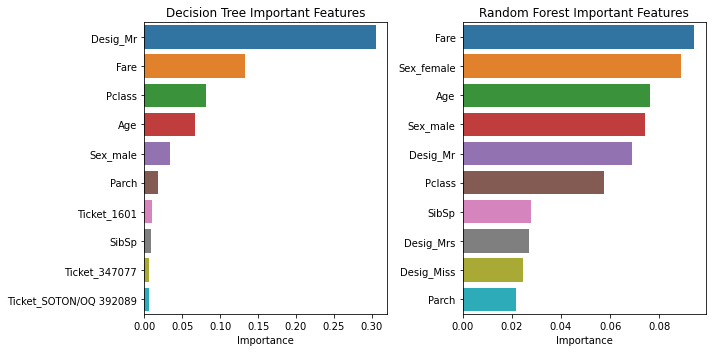

In [75]:
plt.figure(figsize = (10, 5))
plt.subplot(121)
sb.barplot(x = 'Importance', y = top_dt_features.index,
           data = top_dt_features)
plt.title('Decision Tree Important Features')

plt.subplot(122)
sb.barplot(x = 'Importance', y = top_rf_features.index,
           data = top_rf_features)
plt.title('Random Forest Important Features')
plt.tight_layout()
plt.show()

#### 7.4. Model with Ticket feature removed.

In [76]:
wo_ticket_cols = [mod_train_data.columns.to_list()[i] for i, j in enumerate(mod_train_data.columns.str.startswith('Ticket')) if j == 0]
wo_ticket_train_data =  mod_train_data[wo_ticket_cols]

wo_ticket_cols = [mod_valid_data.columns.to_list()[i] for i, j in enumerate(mod_valid_data.columns.str.startswith('Ticket')) if j == 0]
wo_ticket_valid_data =  mod_valid_data[wo_ticket_cols]

wo_ticket_cols = [mod_test_data.columns.to_list()[i] for i, j in enumerate(mod_test_data.columns.str.startswith('Ticket')) if j == 0]
wo_ticket_test_data =  mod_test_data[wo_ticket_cols]

In [77]:
# Without ticket data.

classifiers = [lrclf, sgdclf, dtclf, rfclf, gbclf, svclf, knnclf]

for classifier in classifiers:
    clf_scores = cross_val_score(classifier, X = wo_ticket_train_data, 
                                 y = y_train, cv = 10)
    print(f'Score of {classifier} model:', np.round(clf_scores.mean(), 4))

Score of LogisticRegression() model: 0.8224
Score of SGDClassifier() model: 0.8139
Score of DecisionTreeClassifier(random_state=0) model: 0.7615
Score of RandomForestClassifier(random_state=0) model: 0.8138
Score of GradientBoostingClassifier(random_state=0) model: 0.818
Score of SVC() model: 0.8294
Score of KNeighborsClassifier() model: 0.8223


#### 7.5. Hyperparameter Tuning.

In [83]:
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve, precision_score, recall_score

##### 7.6. Gradient Boosting Tuning.

In [82]:
# Thersholds

bgclf = GradientBoostingClassifier(random_state = 0)

cvp_res = cross_val_predict(bgclf, mod_train_data, y_train, cv = 10,
                            method = 'predict_proba')

In [93]:
precisions, recalls, thresholds = precision_recall_curve(y_train, cvp_res[:, 0])

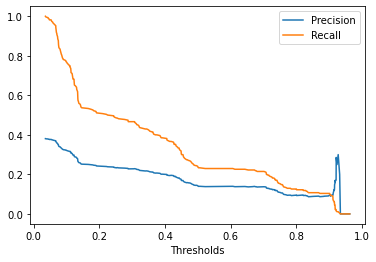

In [97]:
plt.plot(thresholds, precisions[: -1], label = 'Precision')
plt.plot(thresholds, recalls[: -1], label = 'Recall')
plt.xlabel('Thresholds')
plt.legend()
plt.show()

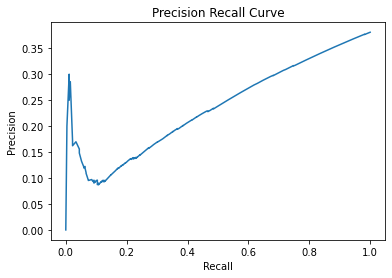

In [99]:
plt.plot(recalls[: -1], precisions[: -1])
plt.title('Precision Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

##### 7.6.1 learning_rate and n_estimators.

In [ ]:
# Aim for High precision.

In [117]:
def hyper_tuning(classifier, params, cv):
    
    gbclf_gscv = GridSearchCV(classifier, param_grid = params, 
                              cv = cv, scoring = 'accuracy')
    gb_res = gbclf_gscv.fit(X = mod_train_data, y = y_train)
    
    pred_train = gbclf_gscv.predict(mod_train_data)
    pred_valid = gbclf_gscv.predict(mod_valid_data)

    print('Best Score of the model:', np.round(gb_res.best_score_.mean(), 4))
    print('Best parameter of the model:', gb_res.best_params_)
    
    print('Training data')
    print('Accuracy:', np.round(accuracy_score(y_true = y_train, 
                                               y_pred = pred_train), 4))
    print('Precision:', np.round(precision_score(y_true = y_train, 
                                                 y_pred = pred_train, 
                                                 average = 'macro'), 4))
    print('Recall:', np.round(recall_score(y_true = y_train, 
                                           y_pred = pred_train,
                                           average = 'macro'), 4))
    
    
    print('\nValidation data')
    print('Accuracy:', np.round(accuracy_score(y_true = y_valid, 
                                               y_pred = pred_valid), 4))
    print('Precision:', np.round(precision_score(y_true = y_valid, 
                                                 y_pred = pred_valid,
                                                 average = 'macro'), 4))
    print('Recall:', np.round(recall_score(y_true = y_valid, 
                                           y_pred = pred_valid,
                                           average = 'macro'), 4))

In [101]:
params = {'learning_rate': [0.1, 0.2, 0.5, 0.8, 1],
          'n_estimators': [200, 300, 400, 500]}

gbclf = GradientBoostingClassifier(random_state = 0)

hyper_tuning(gbclf, params, cv = 10)

Best Score of the model: 0.8534
Best parameter of the model: {'learning_rate': 0.5, 'n_estimators': 300}
Accuracy on Training data: 1.0
Accuracy on Validation data: 0.8101


##### 7.6.2 max_depth and max_features.

In [118]:
params = {'max_depth': [5, 10, 15, 20],
          'max_features': [20, 40, 60, 80]}

gbclf = GradientBoostingClassifier(learning_rate = 0.5, n_estimators = 300,
                                   random_state = 0)

hyper_tuning(gbclf, params, cv = 10)

Best Score of the model: 0.8548
Best parameter of the model: {'max_depth': 15, 'max_features': 60}
Training data
Accuracy: 1.0
Precision: 1.0
Recall: 1.0

Validation data
Accuracy: 0.8101
Precision: 0.8045
Recall: 0.7887


##### 7.6.3 Tuning to lower overfitting.

In [121]:
def overfit_tuning(classifier):
    
    classifier.fit(X = mod_train_data, y = y_train)
    
    pred_train = classifier.predict(mod_train_data)
    pred_valid = classifier.predict(mod_valid_data)
    
    print('Training data')
    print('Accuracy:', np.round(accuracy_score(y_true = y_train, 
                                               y_pred = pred_train), 4))
    print('Precision:', np.round(precision_score(y_true = y_train, 
                                                 y_pred = pred_train, 
                                                 average = 'macro'), 4))
    print('Recall:', np.round(recall_score(y_true = y_train, 
                                           y_pred = pred_train,
                                           average = 'macro'), 4))
    
    
    print('\nValidation data')
    print('Accuracy:', np.round(accuracy_score(y_true = y_valid, 
                                               y_pred = pred_valid), 4))
    print('Precision:', np.round(precision_score(y_true = y_valid, 
                                                 y_pred = pred_valid,
                                                 average = 'macro'), 4))
    print('Recall:', np.round(recall_score(y_true = y_valid, 
                                           y_pred = pred_valid,
                                           average = 'macro'), 4))

In [ ]:
# gbclf = GradientBoostingClassifier(learning_rate = 0.5, n_estimators = 300,
#                                    max_depth = 10, random_state = 0)
# Training data
# Accuracy: 1.0
# Precision: 1.0
# Recall: 1.0

# Validation data
# Accuracy: 0.8156
# Precision: 0.8097
# Recall: 0.796

# Changing max_depth to 5

In [184]:
gbclf = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 5,
                                   max_depth = 10, random_state = 0)

overfit_tuning(gbclf)

Training data
Accuracy: 0.9323
Precision: 0.9507
Recall: 0.9111

Validation data
Accuracy: 0.838
Precision: 0.857
Recall: 0.8034


##### 7.6.4 Tuning learning rate and estimators.

In [159]:
fraction = 20
gbclf = GradientBoostingClassifier(learning_rate = 0.5*(1/fraction), 
                                   n_estimators = 5*(fraction),
                                   max_depth = 10, random_state = 0)

overfit_tuning(gbclf)

Training data
Accuracy: 0.9986
Precision: 0.9989
Recall: 0.9981

Validation data
Accuracy: 0.8436
Precision: 0.8479
Recall: 0.8187


In [160]:
fraction = 50
gbclf = GradientBoostingClassifier(learning_rate = 0.5*(1/fraction), 
                                   n_estimators = 5*(fraction),
                                   max_depth = 10, random_state = 0)

gbclf.fit(X = mod_train_data, y = y_train)

pred_train = gbclf.predict(X = mod_train_data)
print('Accuracy on Training data:', accuracy_score(y_true = y_train, 
                                                   y_pred = pred_train))

pred_valid = gbclf.predict(X = mod_valid_data)
print('Accuracy on Validation data:', accuracy_score(y_true = y_valid, 
                                                   y_pred = pred_valid))

Accuracy on Training data: 0.998589562764457
Accuracy on Validation data: 0.8379888268156425


##### 7.6.6 Final model.

In [174]:
gbclf = GradientBoostingClassifier(learning_rate = 0.5, n_estimators = 5,
                                   max_depth = 10, random_state = 0)

overfit_tuning(gbclf)

Training data
Accuracy: 0.9901
Precision: 0.9922
Recall: 0.987

Validation data
Accuracy: 0.8492
Precision: 0.8653
Recall: 0.8179


### 8. Predictions.

In [179]:
# Test data predictions.

id_test = pd.read_csv('test.csv')

pred_test = gbclf.predict(X = mod_test_data)

test_df = pd.DataFrame({'PassengerId': id_test['PassengerId'],
                        'Survived': pred_test})
test_df.to_csv('3rdattempt.csv', index = False)

### 9. Kaggle Submissions.

In [174]:
pd.DataFrame(data = [[0.7822, 8741], 
                     [0.78947, 4248]], 
             index = ['First_attempt', 'Second_attempt'], 
             columns = ['Score', 'Rank'])

,Score,Rank
First_attempt,0.78220,8741
Second_attempt,0.78947,4248
